In [1]:
%matplotlib ipympl
from onix.helpers import present_float
from onix.models.schiff import inverse_fa_limit, axion_frequency_to_mass, axion_mass_to_frequency
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import scipy.constants as c
from uncertainties import unumpy
from astropy.timeseries import LombScargle
from onix.analysis.functions.lf_ramsey_shared import analyze_data
from onix.analysis.functions.lf_spectroscopy_quick_state_prep_axion import get_results
from onix.papers.axion_2024.lomb_scargle import frequency_sensitivity_from_experiment_times, ls_psd_to_power_spectrum
from onix.papers.axion_2024.axion_gluon_bounds import best_exp_bounds, worse_exp_bounds, model_dep_theory_bounds, model_indep_theory_bounds
from onix.papers.axion_2024.axion_gluon import S_Flambaum, S_Sushkov, S_geo_mean, E_xtl, theta_from_W_T

In [2]:
raw_data = np.load("raw_data.npz")
start_times = raw_data["start_times"]
end_times = raw_data["end_times"]
Zs = raw_data["Zs"]
W_Ts = raw_data["W_Ts"]

center_times = (start_times + end_times) / 2
center_time_offset = center_times[0]
center_time_offsetted = center_times - center_time_offset
center_time_offsetted_h = center_time_offsetted / 3600
cycle_times = end_times - start_times
num_of_cycles = len(start_times)
total_duration = end_times[-1] - start_times[0]
delta_W_Ts = W_Ts - np.average(W_Ts)

cycle_time_avg = np.average(cycle_times)
cycle_frequency_avg = 1 / cycle_time_avg
W_T_unc = np.std(W_Ts) / np.sqrt(num_of_cycles)

In [3]:
frequency_sensitivities = np.load("frequency_sensitivities.npz")
sensitivity_func = interp1d(frequency_sensitivities["freqs_test"], frequency_sensitivities["sensitivities"])

In [5]:
square_thetas_gm = theta_from_W_T(delta_W_Ts, S_geo_mean, E_xtl, absolute=False) ** 2

In [7]:
ls = LombScargle(center_times, square_thetas_gm, normalization="psd")

min_freq = 0.5 / total_duration
max_freq = 0.5 / cycle_time_avg
fs, f_square_thetas_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
power_square_thetas = ls_psd_to_power_spectrum(f_square_thetas_psd, num_of_cycles)
sample_rate = num_of_cycles / total_duration
psd_square_thetas = f_square_thetas_psd * 2 / sample_rate

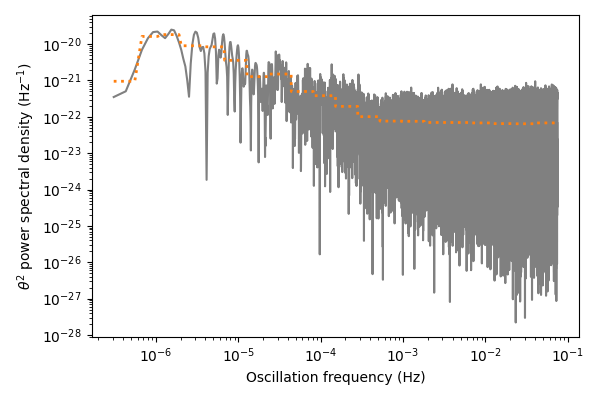

In [11]:
fs_bins = np.logspace(np.log10(np.min(fs) - 1e-10), np.log10(np.max(fs) + 1e-10), 20 + 1)
square_theta_binned_indices = np.digitize(fs, fs_bins)
square_theta_binned = []
for kk in range(1, len(fs_bins)):
    psd_square_theta_same_bin = psd_square_thetas[square_theta_binned_indices==kk]
    square_theta_binned.extend([np.average(psd_square_theta_same_bin)] * len(psd_square_theta_same_bin))
square_theta_binned = np.array(square_theta_binned)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, psd_square_thetas, label="data", color="gray")
ax.plot(fs, square_theta_binned, label="binned average", color="C1", ls="dotted", linewidth=2)
ax.set_ylabel("$\\theta^2$ power spectral density (Hz$^{-1}$)")
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
plt.tight_layout()
plt.show()